In [7]:
import os
import sys
from pathlib import Path

import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw

try:
    current_dir = Path(__file__).resolve().parent
except NameError:
    current_dir = Path.cwd()

project_root = current_dir
while not (project_root/'.git').exists():
    project_root=project_root.parent

print(f'Project root found at: {project_root}')
sys.path.append(project_root)
# import utils
from utils import molecule_standardize


Project root found at: /Users/ldeng/Documents/gitrepos/stpy


In [2]:
import rdkit

print(rdkit.__version__)

2025.03.6


In [ ]:
# print(safe_canonicalsmi_from_smiles.__doc__)

Safely generate canonical SMILES from input SMILES string.

    Args:
        smi (string): SMILES string.

    Returns:
        string: Canonical SMILES string.

    Examples:
        >>> smiles = 'C1=CC=CC=C1OCOC'
        >>> canon_smi = safe_canonicalsmi_from_smiles(smiles)
        >>> print(canon_smi)
        COC1=CC=CC=C1O

        >>> a =['COCCCN', 'c1ccccc1OCOC', None, 'C1CCCCC1O', 'C1=CC=CC=C1', 'invalid_smiles'] 
        >>> df = pd.DataFrame({'smiles': a})
        >>> df['canonical_smi'] = df['smiles'].apply(safe_canonicalsmi_from_smiles)
        >>> print(df) 
        smiles canonical_smi
        0          COCCCN        COCCCN
        1    c1ccccc1OCOC  COCOc1ccccc1
        2            None          None
        3       C1CCCCC1O     OC1CCCCC1
        4     C1=CC=CC=C1      c1ccccc1
        5  invalid_smiles          None
    


[12:06:40] Initializing Normalizer
[12:06:40] Running Normalizer
[12:06:40] Running Normalizer
[12:06:40] Rule applied: Recombine 1,3-separated charges
[12:06:40] Running FragmentRemover
[12:06:40] Running FragmentRemover
[12:06:40] Removed fragment: chlorine
[12:06:40] Removed fragment: sodium
[12:06:40] Removed fragment: ethanol
[12:06:40] Initializing MetalDisconnector
[12:06:40] Initializing MetalDisconnector
[12:06:40] Running MetalDisconnector
[12:06:40] Running MetalDisconnector
[12:06:40] Initializing Normalizer
[12:06:40] Initializing Normalizer
[12:06:40] Running Normalizer
[12:06:40] Running Normalizer


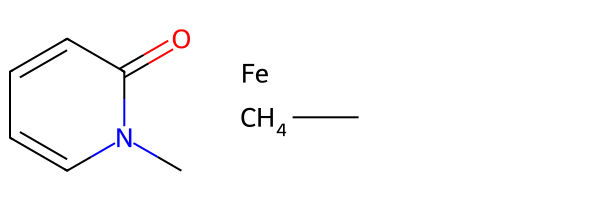

In [8]:
smiles = ['[O-]c1[n+](C)cccc1', 'CC.[Na+].[Cl-].C.[Fe].CCO']
mols = molecule_standardize(smiles)
img = Draw.MolsToGridImage([Chem.MolFromSmiles(m) for m in mols], useSVG=True)
# svg = img.data # SVG string
# svg
# img.save('standardized_molecules.png')
img

In [ ]:
from rdkit import RDLogger
from utils import MoleculeStandardizer

RDLogger.DisableLog("rdApp.*")  # optional: silence RDKit warnings

std = MoleculeStandardizer(
    steps=["normalize", "remove_fragments", "reionize"],
    largest_fragment=True
)
df = pd.DataFrame({ "compound_id": [1, 2, 3], "smiles": [ "CC.[Na+].[Cl-]", "[O-]c1[n+](C)cccc1", "invalid_smiles_here" ] })

df["std_smiles"] = df["smiles"].apply(lambda s: std.standardize_smiles([s])[0] if Chem.MolFromSmiles(s) else None)
df

,compound_id,smiles,std_smiles
0,1,CC.[Na+].[Cl-],CC
1,2,[O-]c1[n+](C)cccc1,Cn1ccccc1=O
2,3,invalid_smiles_here,None


In [153]:
"""
This scripts is aiming at automating the process of summarizing the publications from Google Scholar Alerts.


"""


import email
import imaplib
import logging
import re
import sys
from datetime import datetime, timedelta

import dotenv
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Load environment variables from .env file
dotenv.load_dotenv()

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def fetch_unread_emails(username, password, label="gScholarAlerts", since_days=7):
    # label:gscholaralerts  
    try:
        # Connect to Gmail IMAP server
        mail = imaplib.IMAP4_SSL("imap.gmail.com")
        mail.login(username, password)
        
        # Select emails from the specific label (default: 'gscholaralerts')
        status, _ = mail.select(f'"{label}"')  # Ensure label exists & use double quotes

        if status != "OK":
            logging.error(f"Failed to select label: {label}")
            return None, []

        # Calculate date filter (IMAP format: DD-MMM-YYYY)
        since_date = (datetime.today() - timedelta(days=since_days)).strftime("%d-%b-%Y")

        # Search query within the label instead of inbox
        # search_query = f'(UNSEEN FROM "scholaralerts-noreply@google.com" SINCE {since_date})'
        search_query = f'(ALL FROM "scholaralerts-noreply@google.com" SINCE {since_date})' # change to "UNSEEN" to get all unseen emails
        status, messages = mail.search(None, search_query)

        if status != "OK":
            logging.error(f"Search command failed for label: {label}")
            return None, []

        email_ids = messages[0].split()
        logging.info(f"Fetched {len(email_ids)} emails from label '{label}' since {since_date}.")
        
        return mail, email_ids
    except Exception as e:
        logging.error(f"Failed to fetch emails: {e}")
        return None, []


def parse_email(mail, email_id):
    try:
        status, msg_data = mail.fetch(email_id, "(RFC822)")
        msg = email.message_from_bytes(msg_data[0][1])
        if msg.is_multipart():
            for part in msg.walk():
                if part.get_content_type() == "text/html":
                    return part.get_payload(decode=True)
        else:
            return msg.get_payload(decode=True)
    except Exception as e:
        logging.error(f"Failed to parse email {email_id}: {e}")
        return None
    

def extract_publication_details(html_content):
    try:
        soup = BeautifulSoup(html_content, "html.parser")
        publications = []
        for item in soup.find_all("div", class_="gs or gt"): # gs_r gs_or gs_scl
            title = item.find("h3", class_="gse_alrt_title").text # gs_rt
            authors = item.find("div", class_="gs_a").text
            abstract = item.find("div", class_="gs_rs").text
            url = item.find("h3", class_="gse_alrt_title").find("a")["href"]
            publication_year = item.find("div", class_="gs_a").text.split()[-1]
            publications.append({
                "Title": title,
                "Authors": authors,
                "Abstract": abstract,
                "URL": url,
                "Publication Year": publication_year
            })
        logging.info(f"Extracted {len(publications)} publications.")
        return publications
    except Exception as e:
        logging.error(f"Failed to extract publication details: {e}")
        return []



def summarize_publications(username, password):
    mail, email_ids = fetch_unread_emails(username, password)
    if not mail:
        logging.error("Failed to connect to mail server.")
        return
    all_publications = []
    for email_id in email_ids:
        html_content = parse_email(mail, email_id)
        if html_content:
            publications = extract_publication_details(html_content)
            all_publications.extend(publications)
    mail.logout()
    if all_publications:
        df = pd.DataFrame(all_publications)
        df.to_csv("publications_summary.csv", index=False)
        logging.info("Summary saved to publications_summary.csv")
    else:
        logging.info("No publications found.")


In [154]:
from dotenv import load_dotenv

load_dotenv()  # Load variables from .env file

username = os.getenv("GMAIL_USERNAME")
password = os.getenv("GMAIL_PASSWORD")

print(username, password)

denglh2809@gmail.com urdxdiiikxeaxgmz


In [155]:
mail, email_ids = fetch_unread_emails(username, password)

2025-04-19 21:15:26,683 - INFO - Fetched 4 emails from label 'gScholarAlerts' since 12-Apr-2025.


In [156]:
all_publications = []

for email_id in email_ids:
        html_content = parse_email(mail, email_id)
        print(html_content)
        if html_content:
            publications = extract_publication_details(html_content)
            all_publications.extend(publications)
            print(publications)

2025-04-19 21:15:26,879 - INFO - Extracted 0 publications.
2025-04-19 21:15:27,052 - INFO - Extracted 0 publications.


b'<!doctype html><html xmlns="http://www.w3.org/1999/xhtml" xmlns:o="urn:schemas-microsoft-com:office:office"><head><!--[if gte mso 9]><xml><o:OfficeDocumentSettings><o:AllowPNG/><o:PixelsPerInch>96</o:PixelsPerInch></o:OfficeDocumentSettings></xml><![endif]--><style>body{background-color:#fff}.gse_alrt_title{text-decoration:none}.gse_alrt_title:hover{text-decoration:underline} @media screen and (max-width: 599px) {.gse_alrt_sni br{display:none;}}</style></head><body><!--[if gte mso 9]><table cellpadding="0" cellspacing="0" border="0"><tr><td style="width:600px"><![endif]--><div style="font-family:arial,sans-serif;font-size:13px;line-height:16px;color:#222;width:100%;max-width:600px"><h3 style="font-weight:lighter;font-size:18px;line-height:20px;"></h3><h3 style="font-weight:normal;margin:0;font-size:17px;line-height:20px;"><span style="font-size:11px;font-weight:bold;color:#1a0dab;vertical-align:2px">[PDF]</span> <a href="https://scholar.google.com/scholar_url?url=https://arxiv.org/pd

2025-04-19 21:15:27,223 - INFO - Extracted 0 publications.


b'<!doctype html><html xmlns="http://www.w3.org/1999/xhtml" xmlns:o="urn:schemas-microsoft-com:office:office"><head><!--[if gte mso 9]><xml><o:OfficeDocumentSettings><o:AllowPNG/><o:PixelsPerInch>96</o:PixelsPerInch></o:OfficeDocumentSettings></xml><![endif]--><style>body{background-color:#fff}.gse_alrt_title{text-decoration:none}.gse_alrt_title:hover{text-decoration:underline} @media screen and (max-width: 599px) {.gse_alrt_sni br{display:none;}}</style></head><body><!--[if gte mso 9]><table cellpadding="0" cellspacing="0" border="0"><tr><td style="width:600px"><![endif]--><div style="font-family:arial,sans-serif;font-size:13px;line-height:16px;color:#222;width:100%;max-width:600px"><h3 style="font-weight:lighter;font-size:18px;line-height:20px;"></h3><h3 style="font-weight:normal;font-size:18px;line-height:20px;"></h3><h3 style="font-weight:normal;margin:0;font-size:17px;line-height:20px;"><span style="font-size:11px;font-weight:bold;color:#1a0dab;vertical-align:2px">[HTML]</span> <a

2025-04-19 21:15:27,443 - INFO - Extracted 0 publications.


b'<!doctype html><html xmlns="http://www.w3.org/1999/xhtml" xmlns:o="urn:schemas-microsoft-com:office:office"><head><!--[if gte mso 9]><xml><o:OfficeDocumentSettings><o:AllowPNG/><o:PixelsPerInch>96</o:PixelsPerInch></o:OfficeDocumentSettings></xml><![endif]--><style>body{background-color:#fff}.gse_alrt_title{text-decoration:none}.gse_alrt_title:hover{text-decoration:underline} @media screen and (max-width: 599px) {.gse_alrt_sni br{display:none;}}</style></head><body><!--[if gte mso 9]><table cellpadding="0" cellspacing="0" border="0"><tr><td style="width:600px"><![endif]--><div style="font-family:arial,sans-serif;font-size:13px;line-height:16px;color:#222;width:100%;max-width:600px"><h3 style="font-weight:lighter;font-size:18px;line-height:20px;"></h3><h3 style="font-weight:normal;margin:0;font-size:17px;line-height:20px;"><a href="https://scholar.google.com/scholar_url?url=https://pubmed.ncbi.nlm.nih.gov/40231819/&amp;hl=en&amp;sa=X&amp;d=9946589332717196687&amp;ei=Ds4CaPWtDpPOieoP5M

In [157]:
print(len(html_content))

38918


In [158]:
soup = BeautifulSoup(html_content, "html.parser")

In [159]:
soup

<!DOCTYPE html>
<html xmlns="http://www.w3.org/1999/xhtml" xmlns:o="urn:schemas-microsoft-com:office:office"><head><!--[if gte mso 9]><xml><o:OfficeDocumentSettings><o:AllowPNG/><o:PixelsPerInch>96</o:PixelsPerInch></o:OfficeDocumentSettings></xml><![endif]--><style>body{background-color:#fff}.gse_alrt_title{text-decoration:none}.gse_alrt_title:hover{text-decoration:underline} @media screen and (max-width: 599px) {.gse_alrt_sni br{display:none;}}</style></head><body><!--[if gte mso 9]><table cellpadding="0" cellspacing="0" border="0"><tr><td style="width:600px"><![endif]--><div style="font-family:arial,sans-serif;font-size:13px;line-height:16px;color:#222;width:100%;max-width:600px"><h3 style="font-weight:lighter;font-size:18px;line-height:20px;"></h3><h3 style="font-weight:normal;margin:0;font-size:17px;line-height:20px;"><a class="gse_alrt_title" href="https://scholar.google.com/scholar_url?url=https://pubmed.ncbi.nlm.nih.gov/40231819/&amp;hl=en&amp;sa=X&amp;d=9946589332717196687&amp

In [160]:
infos = [{"href": a["href"], "text": a.get_text(), "author - source": a.find_parent("h3").find_next_sibling("div").get_text(strip=True)} for a in soup.find_all("a", class_="gse_alrt_title")]

In [161]:
infos

[{'href': 'https://scholar.google.com/scholar_url?url=https://pubmed.ncbi.nlm.nih.gov/40231819/&hl=en&sa=X&d=9946589332717196687&ei=Ds4CaPWtDpPOieoP5Mi9yAE&scisig=AFWwaea_GPLG5nJEBl1pTNz1Ms68&oi=scholaralrt&hist=i2xMursAAAAJ:2535622216743015599:AFWwaeataOLwo_DgfRqXW5uVI4aK&html=&pos=0&folt=kw-top',
  'text': 'Unlocking the power of imidazoquinolines: recent advances in anticancer and immunotherapeutic strategies',
  'author - source': 'B Choudhury, MM Alam, B Mm, K Chanda\xa0- Future medicinal chemistry'},
 {'href': 'https://scholar.google.com/scholar_url?url=https://clok.uclan.ac.uk/55186/1/55186%2520Singhrao%2520AAM.pdf&hl=en&sa=X&d=13941528218069317788&ei=Ds4CaPWtDpPOieoP5Mi9yAE&scisig=AFWwaea01_PMJdbdlIDZJCaHjfyJ&oi=scholaralrt&hist=i2xMursAAAAJ:2535622216743015599:AFWwaeataOLwo_DgfRqXW5uVI4aK&html=&pos=1&folt=kw-top',
  'text': 'Porphyromonas gingivalis-Lipopolysaccharide and amyloid-beta: A dangerous liaison for impairing memory?',
  'author - source': "SK Singhrao\xa0- Journal o

In [162]:
df = pd.DataFrame(infos)
df

,href,text,author - source
0,https://scholar.google.com/scholar_url?url=htt...,Unlocking the power of imidazoquinolines: rece...,"B Choudhury, MM Alam, B Mm, K Chanda - Future ..."
1,https://scholar.google.com/scholar_url?url=htt...,Porphyromonas gingivalis-Lipopolysaccharide an...,"SK Singhrao - Journal of Alzheimer's Disease, ..."
2,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"SW Rha, MS Chesario, BG Choi, SY Choi, JK Byun..."
3,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"IG Sumantra, P Mota - Journal of the American ..."
4,https://scholar.google.com/scholar_url?url=htt...,ETHICAL CONSIDERATIONS,"L Padilla, F Liberman, J Tello, P Rosas, P Spa..."
5,https://scholar.google.com/scholar_url?url=htt...,Comparison of Different PCI Strategies for Cor...,K Pant MD - 2025
6,https://scholar.google.com/scholar_url?url=htt...,Extended follow-up of the Essential Pro paclit...,"L Padilla, J Tello, P Lamelas"
7,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"CF Pragitara, ME Ananta, IS Taufik, BE Putra… ..."
8,https://scholar.google.com/scholar_url?url=htt...,A probiotic bacterial strain alleviates FLHS i...,"D Li, K Meng, G Liu, Z Wen, Y Han, W Liu, X Xu..."
9,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"N Yasuda, T Tsuda - Journal of the American Co..."


In [163]:
doi_pattern = re.compile(r"10\.\d{4,9}/[-._;()/:A-Z0-9]+", re.IGNORECASE)
df['doi'] = df['href'].apply(lambda x: doi_pattern.search(x).group(0) if doi_pattern.search(x) else None)
df

,href,text,author - source,doi
0,https://scholar.google.com/scholar_url?url=htt...,Unlocking the power of imidazoquinolines: rece...,"B Choudhury, MM Alam, B Mm, K Chanda - Future ...",None
1,https://scholar.google.com/scholar_url?url=htt...,Porphyromonas gingivalis-Lipopolysaccharide an...,"SK Singhrao - Journal of Alzheimer's Disease, ...",None
2,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"SW Rha, MS Chesario, BG Choi, SY Choi, JK Byun...",10.1016/j.jacc.2025.03.061
3,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"IG Sumantra, P Mota - Journal of the American ...",10.1016/j.jacc.2025.03.062
4,https://scholar.google.com/scholar_url?url=htt...,ETHICAL CONSIDERATIONS,"L Padilla, F Liberman, J Tello, P Rosas, P Spa...",None
5,https://scholar.google.com/scholar_url?url=htt...,Comparison of Different PCI Strategies for Cor...,K Pant MD - 2025,None
6,https://scholar.google.com/scholar_url?url=htt...,Extended follow-up of the Essential Pro paclit...,"L Padilla, J Tello, P Lamelas",None
7,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"CF Pragitara, ME Ananta, IS Taufik, BE Putra… ...",10.1016/j.jacc.2025.03.047
8,https://scholar.google.com/scholar_url?url=htt...,A probiotic bacterial strain alleviates FLHS i...,"D Li, K Meng, G Liu, Z Wen, Y Han, W Liu, X Xu...",None
9,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"N Yasuda, T Tsuda - Journal of the American Co...",10.1016/j.jacc.2025.03.024


In [164]:

def get_publication_details(doi):
    """
    Retrieve publication details including abstract using DOI from the CrossRef API.
    """
    base_url = "https://api.crossref.org/works/"
    full_url = f"{base_url}{doi}"

    try:
        response = requests.get(full_url)
        response.raise_for_status()  # Raise an error if the request fails

        data = response.json()["message"]

        # Extract details
        title = data.get("title", ["No title available"])[0]
        authors = [author["given"] + " " + author["family"] for author in data.get("author", [])]
        journal = data.get("container-title", ["No journal info"])[0]
        publication_year = data.get("published-print", {}).get("date-parts", [[None]])[0][0]
        abstract = data.get("abstract", "No abstract available")  # Abstract field

        return {
            # "DOI": doi,
            "Title": title,
            "Authors": authors,
            "Journal": journal,
            "Publication Year": publication_year,
            "Abstract": abstract
        }

    except requests.exceptions.RequestException as e:
        print(f"Error retrieving DOI information: {e}")
        return None

# # Example usage
# doi = "10.1038/s41586-020-2649-2"  # Replace with any valid DOI
# publication_info = get_publication_details(doi)

# if publication_info:
#     print(publication_info)


In [165]:
df['otherinfos'] = df['doi'].apply(lambda x: get_publication_details(x) if x else None)
df

,href,text,author - source,doi,otherinfos
0,https://scholar.google.com/scholar_url?url=htt...,Unlocking the power of imidazoquinolines: rece...,"B Choudhury, MM Alam, B Mm, K Chanda - Future ...",None,None
1,https://scholar.google.com/scholar_url?url=htt...,Porphyromonas gingivalis-Lipopolysaccharide an...,"SK Singhrao - Journal of Alzheimer's Disease, ...",None,None
2,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"SW Rha, MS Chesario, BG Choi, SY Choi, JK Byun...",10.1016/j.jacc.2025.03.061,{'Title': 'TCTAP A-036 Comparison of Clinical ...
3,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"IG Sumantra, P Mota - Journal of the American ...",10.1016/j.jacc.2025.03.062,{'Title': 'TCTAP A-037 De Novo Coronary Lesion...
4,https://scholar.google.com/scholar_url?url=htt...,ETHICAL CONSIDERATIONS,"L Padilla, F Liberman, J Tello, P Rosas, P Spa...",None,None
5,https://scholar.google.com/scholar_url?url=htt...,Comparison of Different PCI Strategies for Cor...,K Pant MD - 2025,None,None
6,https://scholar.google.com/scholar_url?url=htt...,Extended follow-up of the Essential Pro paclit...,"L Padilla, J Tello, P Lamelas",None,None
7,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"CF Pragitara, ME Ananta, IS Taufik, BE Putra… ...",10.1016/j.jacc.2025.03.047,{'Title': 'TCTAP A-028 Comparison of Drug Elut...
8,https://scholar.google.com/scholar_url?url=htt...,A probiotic bacterial strain alleviates FLHS i...,"D Li, K Meng, G Liu, Z Wen, Y Han, W Liu, X Xu...",None,None
9,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"N Yasuda, T Tsuda - Journal of the American Co...",10.1016/j.jacc.2025.03.024,{'Title': 'TCTAP A-008 Mid-Term Outcomes of Dr...


In [166]:
df['url'] = df['href'].apply(lambda x: x.split("scholar_url?url=")[1].split("&")[0])
df

,href,text,author - source,doi,otherinfos,url
0,https://scholar.google.com/scholar_url?url=htt...,Unlocking the power of imidazoquinolines: rece...,"B Choudhury, MM Alam, B Mm, K Chanda - Future ...",None,None,https://pubmed.ncbi.nlm.nih.gov/40231819/
1,https://scholar.google.com/scholar_url?url=htt...,Porphyromonas gingivalis-Lipopolysaccharide an...,"SK Singhrao - Journal of Alzheimer's Disease, ...",None,None,https://clok.uclan.ac.uk/55186/1/55186%2520Sin...
2,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"SW Rha, MS Chesario, BG Choi, SY Choi, JK Byun...",10.1016/j.jacc.2025.03.061,{'Title': 'TCTAP A-036 Comparison of Clinical ...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...
3,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"IG Sumantra, P Mota - Journal of the American ...",10.1016/j.jacc.2025.03.062,{'Title': 'TCTAP A-037 De Novo Coronary Lesion...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...
4,https://scholar.google.com/scholar_url?url=htt...,ETHICAL CONSIDERATIONS,"L Padilla, F Liberman, J Tello, P Rosas, P Spa...",None,None,https://recintervcardiol.org/en/letters-to-the...
5,https://scholar.google.com/scholar_url?url=htt...,Comparison of Different PCI Strategies for Cor...,K Pant MD - 2025,None,None,https://scholarlycommons.libraryinfo.bhs.org/a...
6,https://scholar.google.com/scholar_url?url=htt...,Extended follow-up of the Essential Pro paclit...,"L Padilla, J Tello, P Lamelas",None,None,https://recintervcardiol.org/images/pdf-files/...
7,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"CF Pragitara, ME Ananta, IS Taufik, BE Putra… ...",10.1016/j.jacc.2025.03.047,{'Title': 'TCTAP A-028 Comparison of Drug Elut...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...
8,https://scholar.google.com/scholar_url?url=htt...,A probiotic bacterial strain alleviates FLHS i...,"D Li, K Meng, G Liu, Z Wen, Y Han, W Liu, X Xu...",None,None,https://www.researchsquare.com/article/rs-6449...
9,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"N Yasuda, T Tsuda - Journal of the American Co...",10.1016/j.jacc.2025.03.024,{'Title': 'TCTAP A-008 Mid-Term Outcomes of Dr...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...


In [167]:

# Apply function and expand dictionary into columns
df_expanded = df.apply(lambda row: get_publication_details(row['doi']), axis=1).apply(pd.Series)

# Combine with original DataFrame
df_final = pd.concat([df, df_expanded], axis=1)

df_final

Error retrieving DOI information: 404 Client Error: Not Found for url: https://api.crossref.org/works/None
Error retrieving DOI information: 404 Client Error: Not Found for url: https://api.crossref.org/works/None
Error retrieving DOI information: 404 Client Error: Not Found for url: https://api.crossref.org/works/None
Error retrieving DOI information: 404 Client Error: Not Found for url: https://api.crossref.org/works/None
Error retrieving DOI information: 404 Client Error: Not Found for url: https://api.crossref.org/works/None
Error retrieving DOI information: 404 Client Error: Not Found for url: https://api.crossref.org/works/None


,href,text,author - source,doi,otherinfos,url,Title,Authors,Journal,Publication Year,Abstract
0,https://scholar.google.com/scholar_url?url=htt...,Unlocking the power of imidazoquinolines: rece...,"B Choudhury, MM Alam, B Mm, K Chanda - Future ...",None,None,https://pubmed.ncbi.nlm.nih.gov/40231819/,NaN,NaN,NaN,NaN,NaN
1,https://scholar.google.com/scholar_url?url=htt...,Porphyromonas gingivalis-Lipopolysaccharide an...,"SK Singhrao - Journal of Alzheimer's Disease, ...",None,None,https://clok.uclan.ac.uk/55186/1/55186%2520Sin...,NaN,NaN,NaN,NaN,NaN
2,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"SW Rha, MS Chesario, BG Choi, SY Choi, JK Byun...",10.1016/j.jacc.2025.03.061,{'Title': 'TCTAP A-036 Comparison of Clinical ...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"[Seung-Woon Rha, Manda Satria Chesario, Byoung...",Journal of the American College of Cardiology,2025.0,No abstract available
3,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"IG Sumantra, P Mota - Journal of the American ...",10.1016/j.jacc.2025.03.062,{'Title': 'TCTAP A-037 De Novo Coronary Lesion...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"[I Gede Sumantra, Paula Mota]",Journal of the American College of Cardiology,2025.0,No abstract available
4,https://scholar.google.com/scholar_url?url=htt...,ETHICAL CONSIDERATIONS,"L Padilla, F Liberman, J Tello, P Rosas, P Spa...",None,None,https://recintervcardiol.org/en/letters-to-the...,NaN,NaN,NaN,NaN,NaN
5,https://scholar.google.com/scholar_url?url=htt...,Comparison of Different PCI Strategies for Cor...,K Pant MD - 2025,None,None,https://scholarlycommons.libraryinfo.bhs.org/a...,NaN,NaN,NaN,NaN,NaN
6,https://scholar.google.com/scholar_url?url=htt...,Extended follow-up of the Essential Pro paclit...,"L Padilla, J Tello, P Lamelas",None,None,https://recintervcardiol.org/images/pdf-files/...,NaN,NaN,NaN,NaN,NaN
7,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"CF Pragitara, ME Ananta, IS Taufik, BE Putra… ...",10.1016/j.jacc.2025.03.047,{'Title': 'TCTAP A-028 Comparison of Drug Elut...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"[Chiquita Febby Pragitara, Muammar Emir Ananta...",Journal of the American College of Cardiology,2025.0,No abstract available
8,https://scholar.google.com/scholar_url?url=htt...,A probiotic bacterial strain alleviates FLHS i...,"D Li, K Meng, G Liu, Z Wen, Y Han, W Liu, X Xu...",None,None,https://www.researchsquare.com/article/rs-6449...,NaN,NaN,NaN,NaN,NaN
9,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"N Yasuda, T Tsuda - Journal of the American Co...",10.1016/j.jacc.2025.03.024,{'Title': 'TCTAP A-008 Mid-Term Outcomes of Dr...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"[Nao Yasuda, Takuma Tsuda]",Journal of the American College of Cardiology,2025.0,No abstract available


In [168]:
import re
from io import BytesIO

import fitz  # PyMuPDF


def is_pdf_url(url):
    """
    Check if the URL points to a PDF file by examining headers.
    """
    response = requests.head(url, allow_redirects=True)
    return response.headers.get("Content-Type") == "application/pdf"


def extract_text_from_pdf(pdf_url):
    """
    Download a PDF from a URL and extract its text without saving it locally.
    """
    response = requests.get(pdf_url)
    if response.status_code == 200:
        pdf_stream = BytesIO(response.content)  # Load PDF into memory
        doc = fitz.open(stream=pdf_stream, filetype="pdf")  # Open PDF in memory
        text = "\n".join([page.get_text("text") for page in doc])  # Extract text from all pages
        doc.close()  # Close the document
        pdf_stream.close()
        return text
    else:
        print("Failed to fetch PDF.")
        return None


def extract_text_from_webpage(web_url):
    """
    Extract text from an HTML webpage.
    """
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(web_url, headers=headers)
    
    if response.status_code != 200:
        print(f"Failed to fetch webpage: {web_url}")
        return None
    
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Find the "Abstract" element
    abstract_tag = soup.find(lambda tag: tag.name in ["h2", "h3", "strong"] and "abstract" in tag.text.lower())

    if abstract_tag:
        # Get the next sibling that contains text
        next_tag = abstract_tag.find_next_sibling()
        abstract_text = next_tag.text.strip() if next_tag else "No abstract found"
    else:
        abstract_text = "Abstract heading not found"

    return {"Abstract": abstract_text}


def extract_publication_info(url):
    """
    Extract publication details based on whether the URL is a PDF or a web page.
    """
    if is_pdf_url(url):
        text = extract_text_from_pdf(url)
        if text:
            # Extract title (assuming it's capitalized and at the start)
            title_match = re.search(r"(?:(?:[A-Z][a-z]+)\s+){3,}", text)
            title = title_match.group(0) if title_match else "Title not found"

            # Extract authors (assuming they appear in a format like: "Author 1, Author 2, ...")
            authors_match = re.search(r"(?:(?:[A-Za-z\-]+),\s*){2,}", text)
            authors = authors_match.group(0) if authors_match else "Authors not found"

            # Extract abstract (assuming it starts with 'Abstract' and ends before 'Introduction')
            # abstract_match = re.search(r"Abstract([\s\S]*?)Introduction", text, re.IGNORECASE)
            abstract_match = re.search(r"Abstract([\s\S]+?)(?:\n[A-Z][a-z]+\s*\n|\Z)", text, re.IGNORECASE)

            abstract = abstract_match.group(1).strip() if abstract_match else "Abstract not found"

            return {"Title": title, "Authors": authors, "Abstract": abstract}
        else:
            return None
    else:
        return extract_text_from_webpage(url)

# Example usage
# pdf_url = "https://example.com/sample.pdf"  # Replace with a valid PDF URL
# pdf_info = extract_text_from_webpage(pdf_url)

In [169]:
pdf_url = "https://clok.uclan.ac.uk/55186/1/55186%20Singhrao%20AAM.pdf"  # Replace with a valid PDF URL
pdf_url = "https://www.beilstein-journals.org/bjoc/articles/21/61"
pdf_info = extract_text_from_webpage(pdf_url)
pdf_info

{'Abstract': 'In this review, we describe recent advances in electrochemical green methods for the synthesis of various organophosphorus compounds through the formation of phosphorus–carbon, phosphorus–nitrogen, phosphorus–oxygen, phosphorus–sulfur, and phosphorus–selenium bonds. The impact of different electrodes is also discussed in this matter. Graphite, platinum, RVC, and nickel electrodes have been used extensively for the electrochemical synthesis of organophosphorus compounds. The recent advances in the electrochemical synthesis of organophosphorus compounds have made this method a promising method for preparing various structures. This review is an introduction to encourage scientists to use electrosynthesis as a green, precise, and low-cost method to prepare phosphorous structures.'}

In [170]:
df_expanded = df.apply(lambda row: extract_text_from_webpage(row['url']), axis=1).apply(pd.Series)
df_expanded

Failed to fetch webpage: https://www.jacc.org/doi/full/10.1016/j.jacc.2025.03.061
Failed to fetch webpage: https://www.jacc.org/doi/full/10.1016/j.jacc.2025.03.062
Failed to fetch webpage: https://www.jacc.org/doi/full/10.1016/j.jacc.2025.03.047
Failed to fetch webpage: https://www.jacc.org/doi/full/10.1016/j.jacc.2025.03.024


,Abstract
0,The challenges in drug discovery aiming to mit...
1,Abstract heading not found
2,NaN
3,NaN
4,Abstract heading not found
5,Background: Though superior to bare-metal sten...
6,Abstract heading not found
7,NaN
8,Abstract heading not found
9,NaN


In [171]:
df_final = pd.concat([df_final, df_expanded], axis=1)
df_final

,href,text,author - source,doi,otherinfos,url,Title,Authors,Journal,Publication Year,Abstract,Abstract
0,https://scholar.google.com/scholar_url?url=htt...,Unlocking the power of imidazoquinolines: rece...,"B Choudhury, MM Alam, B Mm, K Chanda - Future ...",None,None,https://pubmed.ncbi.nlm.nih.gov/40231819/,NaN,NaN,NaN,NaN,NaN,The challenges in drug discovery aiming to mit...
1,https://scholar.google.com/scholar_url?url=htt...,Porphyromonas gingivalis-Lipopolysaccharide an...,"SK Singhrao - Journal of Alzheimer's Disease, ...",None,None,https://clok.uclan.ac.uk/55186/1/55186%2520Sin...,NaN,NaN,NaN,NaN,NaN,Abstract heading not found
2,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"SW Rha, MS Chesario, BG Choi, SY Choi, JK Byun...",10.1016/j.jacc.2025.03.061,{'Title': 'TCTAP A-036 Comparison of Clinical ...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"[Seung-Woon Rha, Manda Satria Chesario, Byoung...",Journal of the American College of Cardiology,2025.0,No abstract available,NaN
3,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"IG Sumantra, P Mota - Journal of the American ...",10.1016/j.jacc.2025.03.062,{'Title': 'TCTAP A-037 De Novo Coronary Lesion...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"[I Gede Sumantra, Paula Mota]",Journal of the American College of Cardiology,2025.0,No abstract available,NaN
4,https://scholar.google.com/scholar_url?url=htt...,ETHICAL CONSIDERATIONS,"L Padilla, F Liberman, J Tello, P Rosas, P Spa...",None,None,https://recintervcardiol.org/en/letters-to-the...,NaN,NaN,NaN,NaN,NaN,Abstract heading not found
5,https://scholar.google.com/scholar_url?url=htt...,Comparison of Different PCI Strategies for Cor...,K Pant MD - 2025,None,None,https://scholarlycommons.libraryinfo.bhs.org/a...,NaN,NaN,NaN,NaN,NaN,Background: Though superior to bare-metal sten...
6,https://scholar.google.com/scholar_url?url=htt...,Extended follow-up of the Essential Pro paclit...,"L Padilla, J Tello, P Lamelas",None,None,https://recintervcardiol.org/images/pdf-files/...,NaN,NaN,NaN,NaN,NaN,Abstract heading not found
7,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"CF Pragitara, ME Ananta, IS Taufik, BE Putra… ...",10.1016/j.jacc.2025.03.047,{'Title': 'TCTAP A-028 Comparison of Drug Elut...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"[Chiquita Febby Pragitara, Muammar Emir Ananta...",Journal of the American College of Cardiology,2025.0,No abstract available,NaN
8,https://scholar.google.com/scholar_url?url=htt...,A probiotic bacterial strain alleviates FLHS i...,"D Li, K Meng, G Liu, Z Wen, Y Han, W Liu, X Xu...",None,None,https://www.researchsquare.com/article/rs-6449...,NaN,NaN,NaN,NaN,NaN,Abstract heading not found
9,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"N Yasuda, T Tsuda - Journal of the American Co...",10.1016/j.jacc.2025.03.024,{'Title': 'TCTAP A-008 Mid-Term Outcomes of Dr...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"[Nao Yasuda, Takuma Tsuda]",Journal of the American College of Cardiology,2025.0,No abstract available,NaN


In [172]:
# Merge the last two columns, keeping the longest string
df_final["Abstract"] = df_final["Abstract"].astype(str)  # Ensure it's a string

df_final["abstract"] = df_final.apply(lambda row: row.iloc[-2] if len(row.iloc[-2]) > len(row.iloc[-1]) else row.iloc[-1], axis=1)

# Drop the original last two columns (optional)
df_final.drop(columns="Abstract", inplace=True)
df_final

,href,text,author - source,doi,otherinfos,url,Title,Authors,Journal,Publication Year,abstract
0,https://scholar.google.com/scholar_url?url=htt...,Unlocking the power of imidazoquinolines: rece...,"B Choudhury, MM Alam, B Mm, K Chanda - Future ...",None,None,https://pubmed.ncbi.nlm.nih.gov/40231819/,NaN,NaN,NaN,NaN,The challenges in drug discovery aiming to mit...
1,https://scholar.google.com/scholar_url?url=htt...,Porphyromonas gingivalis-Lipopolysaccharide an...,"SK Singhrao - Journal of Alzheimer's Disease, ...",None,None,https://clok.uclan.ac.uk/55186/1/55186%2520Sin...,NaN,NaN,NaN,NaN,Abstract heading not found
2,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"SW Rha, MS Chesario, BG Choi, SY Choi, JK Byun...",10.1016/j.jacc.2025.03.061,{'Title': 'TCTAP A-036 Comparison of Clinical ...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"[Seung-Woon Rha, Manda Satria Chesario, Byoung...",Journal of the American College of Cardiology,2025.0,No abstract available
3,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"IG Sumantra, P Mota - Journal of the American ...",10.1016/j.jacc.2025.03.062,{'Title': 'TCTAP A-037 De Novo Coronary Lesion...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"[I Gede Sumantra, Paula Mota]",Journal of the American College of Cardiology,2025.0,No abstract available
4,https://scholar.google.com/scholar_url?url=htt...,ETHICAL CONSIDERATIONS,"L Padilla, F Liberman, J Tello, P Rosas, P Spa...",None,None,https://recintervcardiol.org/en/letters-to-the...,NaN,NaN,NaN,NaN,Abstract heading not found
5,https://scholar.google.com/scholar_url?url=htt...,Comparison of Different PCI Strategies for Cor...,K Pant MD - 2025,None,None,https://scholarlycommons.libraryinfo.bhs.org/a...,NaN,NaN,NaN,NaN,Background: Though superior to bare-metal sten...
6,https://scholar.google.com/scholar_url?url=htt...,Extended follow-up of the Essential Pro paclit...,"L Padilla, J Tello, P Lamelas",None,None,https://recintervcardiol.org/images/pdf-files/...,NaN,NaN,NaN,NaN,Abstract heading not found
7,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"CF Pragitara, ME Ananta, IS Taufik, BE Putra… ...",10.1016/j.jacc.2025.03.047,{'Title': 'TCTAP A-028 Comparison of Drug Elut...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"[Chiquita Febby Pragitara, Muammar Emir Ananta...",Journal of the American College of Cardiology,2025.0,No abstract available
8,https://scholar.google.com/scholar_url?url=htt...,A probiotic bacterial strain alleviates FLHS i...,"D Li, K Meng, G Liu, Z Wen, Y Han, W Liu, X Xu...",None,None,https://www.researchsquare.com/article/rs-6449...,NaN,NaN,NaN,NaN,Abstract heading not found
9,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"N Yasuda, T Tsuda - Journal of the American Co...",10.1016/j.jacc.2025.03.024,{'Title': 'TCTAP A-008 Mid-Term Outcomes of Dr...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"[Nao Yasuda, Takuma Tsuda]",Journal of the American College of Cardiology,2025.0,No abstract available


In [173]:
df_final

,href,text,author - source,doi,otherinfos,url,Title,Authors,Journal,Publication Year,abstract
0,https://scholar.google.com/scholar_url?url=htt...,Unlocking the power of imidazoquinolines: rece...,"B Choudhury, MM Alam, B Mm, K Chanda - Future ...",None,None,https://pubmed.ncbi.nlm.nih.gov/40231819/,NaN,NaN,NaN,NaN,The challenges in drug discovery aiming to mit...
1,https://scholar.google.com/scholar_url?url=htt...,Porphyromonas gingivalis-Lipopolysaccharide an...,"SK Singhrao - Journal of Alzheimer's Disease, ...",None,None,https://clok.uclan.ac.uk/55186/1/55186%2520Sin...,NaN,NaN,NaN,NaN,Abstract heading not found
2,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"SW Rha, MS Chesario, BG Choi, SY Choi, JK Byun...",10.1016/j.jacc.2025.03.061,{'Title': 'TCTAP A-036 Comparison of Clinical ...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-036 Comparison of Clinical Outcomes Be...,"[Seung-Woon Rha, Manda Satria Chesario, Byoung...",Journal of the American College of Cardiology,2025.0,No abstract available
3,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"IG Sumantra, P Mota - Journal of the American ...",10.1016/j.jacc.2025.03.062,{'Title': 'TCTAP A-037 De Novo Coronary Lesion...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-037 De Novo Coronary Lesions in Dialys...,"[I Gede Sumantra, Paula Mota]",Journal of the American College of Cardiology,2025.0,No abstract available
4,https://scholar.google.com/scholar_url?url=htt...,ETHICAL CONSIDERATIONS,"L Padilla, F Liberman, J Tello, P Rosas, P Spa...",None,None,https://recintervcardiol.org/en/letters-to-the...,NaN,NaN,NaN,NaN,Abstract heading not found
5,https://scholar.google.com/scholar_url?url=htt...,Comparison of Different PCI Strategies for Cor...,K Pant MD - 2025,None,None,https://scholarlycommons.libraryinfo.bhs.org/a...,NaN,NaN,NaN,NaN,Background: Though superior to bare-metal sten...
6,https://scholar.google.com/scholar_url?url=htt...,Extended follow-up of the Essential Pro paclit...,"L Padilla, J Tello, P Lamelas",None,None,https://recintervcardiol.org/images/pdf-files/...,NaN,NaN,NaN,NaN,Abstract heading not found
7,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"CF Pragitara, ME Ananta, IS Taufik, BE Putra… ...",10.1016/j.jacc.2025.03.047,{'Title': 'TCTAP A-028 Comparison of Drug Elut...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-028 Comparison of Drug Eluting Stents-...,"[Chiquita Febby Pragitara, Muammar Emir Ananta...",Journal of the American College of Cardiology,2025.0,No abstract available
8,https://scholar.google.com/scholar_url?url=htt...,A probiotic bacterial strain alleviates FLHS i...,"D Li, K Meng, G Liu, Z Wen, Y Han, W Liu, X Xu...",None,None,https://www.researchsquare.com/article/rs-6449...,NaN,NaN,NaN,NaN,Abstract heading not found
9,https://scholar.google.com/scholar_url?url=htt...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"N Yasuda, T Tsuda - Journal of the American Co...",10.1016/j.jacc.2025.03.024,{'Title': 'TCTAP A-008 Mid-Term Outcomes of Dr...,https://www.jacc.org/doi/full/10.1016/j.jacc.2...,TCTAP A-008 Mid-Term Outcomes of Drug-Coated B...,"[Nao Yasuda, Takuma Tsuda]",Journal of the American College of Cardiology,2025.0,No abstract available
